In [1]:
system.time({source("paper_utils.R")})


Attaching package: ‘Rcpp’

The following object is masked from ‘package:inline’:

    registerPlugin


Attaching package: ‘singlecellmethods’

The following object is masked _by_ ‘.GlobalEnv’:

    normalizeData



   user  system elapsed 
 21.609   6.592  41.456 

In [ ]:
cachedir <- "/data/srlab/ik936/NOTCH/data/cache/"
tissue <- readRDS(file.path(cachedir, "analysis_sc_tissue.rds"))
joint <- readRDS(file.path(cachedir, "analysis_sc_tissue_mm.rds"))
bulk <- readRDS(file.path(cachedir, "bulk_data.rds"))

data_if <- fread("/data/srlab/ik936/NOTCH/paper/if_distances.txt") %>% 
    data.frame() %>% 
    subset(ncells_image > 1000) %>% 
    dplyr::mutate(Sample = ifelse(Sample == '183_C', 'RA183', Sample)) ## to make labels more consistent with filenames

In [14]:
nice_name <- c(pericytes = "Pericytes", lining = "Lining Fibroblasts", sublining = "Sublining Fibroblasts", 
               sublining_cd34 = "Sublining Fibroblasts", endothelial = "Blood Vessel Cells", 
               oa = "Tissue OA", ra = "Tissue RA", MM1 = "fibroblast organoid", 
               MM2 = "fibroblast + blood vessel\norganoid", Tissue = "synovial tissue", 
              endo_st = "blood vessel cells", 
                peri_st = "pericytes", 
                endo_mm = "blood vessel cells",
                peri_mm = "fibroblasts + pericytes",
               primary = "Synovial Tissue", culture = "Organoid",
               blood = "Blood vessel cells", lymph = "Lymphatic vessel cells"
)
nice_names <- data.frame(nice_name, stringsAsFactors = FALSE) %>% tibble::rownames_to_column("given_name")
nice_names_list <- nice_name
# nice_names

In [82]:
bin_95 <- function (data_df, xvar, yvars, num.bin, .include.lowest = TRUE) 
{
    data_df <- data.frame(data_df)
    x <- data_df[[xvar]]
    .breaks <- unique(quantile(x, probs = seq(0, 1, length.out = num.bin)))
    bin_means <- 0.5 * (head(.breaks, -1) + tail(.breaks, -1))
    bins_freq <- cut(x, .breaks, include.lowest = .include.lowest)
    levels(bins_freq) <- bin_means
    xmeans <- lapply(split(x, as.integer(bins_freq)), mean) %>% 
        as.numeric
    res_df <- Reduce(rbind, lapply(yvars, function(yvar) {
        y <- data_df[[yvar]]
        ymeans <- lapply(split(y, as.integer(bins_freq)), mean) %>% 
            as.numeric
        ysd <- lapply(split(y, as.integer(bins_freq)), sd) %>% 
            as.numeric
        data.frame(xval = xmeans) %>% cbind(Reduce(rbind, lapply(split(y, 
            as.integer(bins_freq)), function(.x) quantile(.x, 
            c(0.05, 0.95)))) %>% data.frame() %>% dplyr::mutate(symbol = yvar)) %>% 
            cbind(yval = ymeans, ysd = ysd)
    })) %>% data.frame()
    return(res_df)
}

# Populations in synovium

## Donor batch effect, before and after

    scatter plots, before and after by donor

In [230]:
fig.size(4, 10)
with(tissue, {
    do_scatter(umap, meta_data, 'donor', pt_size = 4, 
                              palette_use = tableau_color_pal('Tableau 20')(12), do_labels = FALSE) + 
    labs(title = "Before Harmony correction") + 
    do_scatter(umap_harmony, meta_data, 'donor', pt_size = 4, no_guides = FALSE,
                              palette_use = tableau_color_pal('Tableau 20')(12), do_labels = FALSE) + 
    labs(title = "After Harmony correction") + 
    patchwork::plot_annotation(tag_levels = 'A') + 
    NULL    
    ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/umap_batch.pdf', device = "pdf", 
           dpi = 300, width = 10, height = 4, useDingbats = FALSE)    
})



## Major cell types - scatter plot


In [261]:
fig.size(4, 7)
with(tissue, {
    meta_use <- meta_data %>% 
        dplyr::mutate(
            cell_type = case_when(cell_type %in% c('lymph', 'blood') ~ 'Vascular Endothelial Cells',
                      cell_type == 'leukocytes' ~ 'leukocytes', 
                      cell_type == 'pericytes' ~ 'Pericytes', 
                      cell_type == 'sublining' ~ 'Sublining Fibroblasts', 
                      cell_type == 'lining' ~ 'Lining Fibroblasts')
        )
    do_scatter(umap_harmony, meta_use, 'cell_type', pt_size = 3, no_guides = FALSE,
                              palette_use = tableau_color_pal()(6), do_labels = FALSE) + 
    labs(title = "Cell types") + 
    NULL    
    
    ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/umap_types.pdf', device = "pdf", 
           dpi = 300, width = 7, height = 4, useDingbats = FALSE)    
    
})
    

## Major cell types - dot plot

In [232]:
genes_use <- rev(c('PDGFRA', 'PDPN', 'PRG4', 'CD55', 'THY1', 'PDGFRB', 'ACTA2', 'MCAM', 'VWF', 'CD34'))

with(tissue, {
    cell_levels <- c('lining', 'sublining', 'pericytes', 'blood')
    gene_levels <- genes_use
    
    markers_tidy <- dplyr::inner_join(
        markers$pct_in %>% data.frame %>% tibble::rownames_to_column("symbol") %>% 
            tidyr::gather(cluster, pct, -symbol),
        markers$means %>% data.frame %>% tibble::rownames_to_column("symbol") %>% 
            tidyr::gather(cluster, avg_exp, -symbol), 
        by = c("symbol", "cluster")
    )
    X <- markers_tidy %>% 
        subset(symbol %in% gene_levels)

    X$cell_type <- X$cluster
    data_plot <- X %>%
        dplyr::mutate(symbol = factor(symbol, gene_levels)) %>%
        dplyr::mutate(pct = ifelse(is.na(pct), 0, pct)) %>% 
        dplyr::mutate(avg_exp = ifelse(is.na(avg_exp), 0, avg_exp)) %>% 
        dplyr::group_by(symbol) %>% 
        mutate(avg_exp = scale(avg_exp)) %>% 
        mutate(avg_exp_scale = MinMax(avg_exp, max = 2.5, min = -2.5)) %>%
        ungroup() %>%
        identity()
    
    fig.size(4.5, 2.7)
    data_plot %>% 
        dplyr::mutate(cell_type = factor(cell_type, cell_levels)) %>% 
        subset(!is.na(cell_type)) %>% 
        ggplot(aes(cell_type, symbol)) + 
            geom_point(aes(size = 100 * pct, color = avg_exp_scale)) + 
            scale_color_gradient2(mid = 'lightgrey', high = muted('blue'), midpoint = min(data_plot$avg_exp_scale)) + 
            scale_size_area(max_size = 4) + 
            theme(axis.title.x = element_blank(), axis.title.y = element_blank()) + 
            scale_x_discrete(labels = nice_names_list) + 
            theme_tufte() + theme(panel.background = element_rect()) + 
            theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
            labs(x = "", y = "", size = '%Cells\nExpressing', color = 'Mean\nExpression\n(scaled)') + 
            NULL    
    
    ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/dotplot_main.pdf', device = "pdf", 
           dpi = 300, width = 2.7, height = 4.5, useDingbats = FALSE)  
    
})

 

# IF images

## Modeled computationally

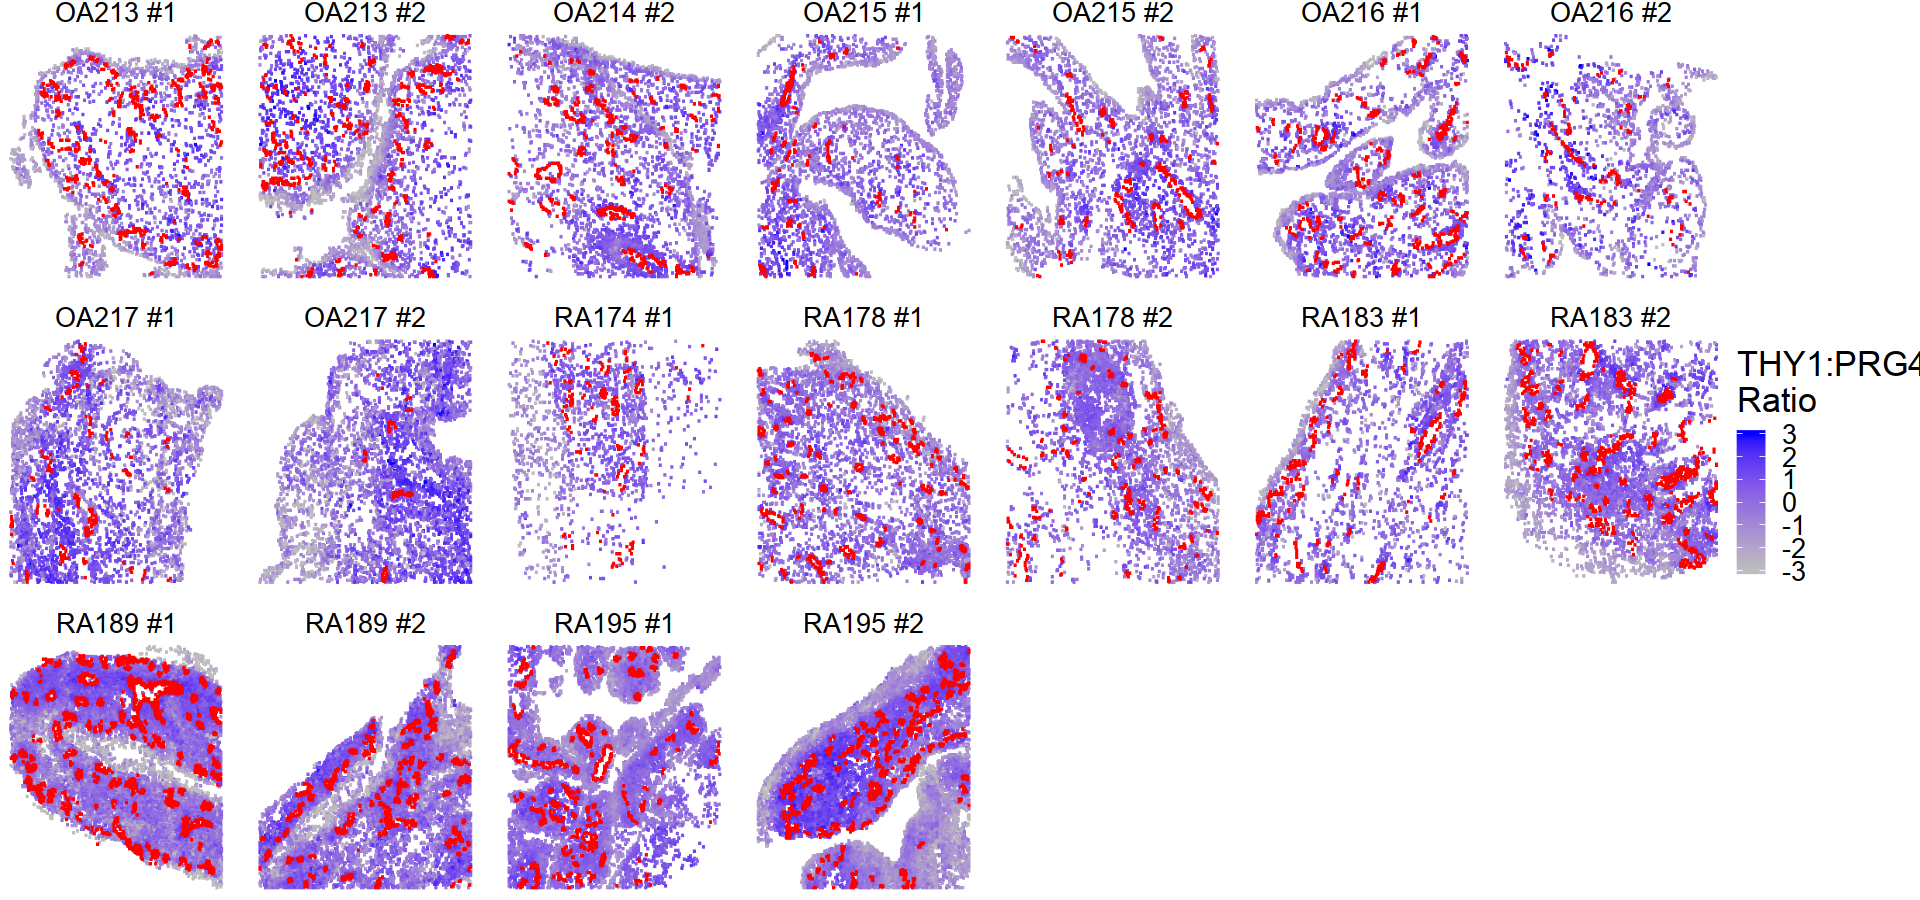

In [273]:
fig.size(7.5, 16)
data_if %>% 
    subset(ncells_image > 1000) %>% 
    dplyr::mutate(ID = sprintf("%s #%s", Sample, Image.number)) %>% 
    ggplot(aes(100 * center_x, 100 * center_y)) + 
        geom_point_rast(dpi = 300, height = 1, width = 1, data = . %>% subset(is_ec != 1), aes(color = ratio), shape = '.') + ## non-ECs
        geom_point_rast(dpi = 300, height = 1, width = 1, data = . %>% subset(cell_type == 'bldvessel' & is_ec == 1), color = 'red', shape = '.') + ## EC cells
        theme_void(base_size = 20, base_family = 'Helvetica') + 
        scale_color_gradient2(mid = "grey", high = "blue", midpoint = -3) + 
        guides(area = FALSE, size = FALSE) + 
        labs(color = 'THY1:PRG4\nRatio') + 
        labs(x = 'x position (um)', y = 'y position (um)') + 
        facet_wrap(~ID, scales = 'free', nrow = 3, ncol = 7) + 
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/if_scatter.pdf', device = "pdf", 
       dpi = 300, width = 16, height = 7.5, useDingbats = FALSE)  


# IF distance from EC

In [269]:
data_if_binned <- split(1:nrow(data_if), paste0(data_if$Sample, data_if$Image.number)) %>% lapply(function(idx) {
    data_if[idx, ] %>% 
        subset(!is.na(dist_EC2)) %>% 
        bin_95("dist_EC2", c("CD146", "ratio"), 100, FALSE) %>% 
        cbind(data_if[idx, ] %>% dplyr::select(Sample, Image.number, ncells_image) %>% unique)
})
data_if_binned <- Reduce(rbind, data_if_binned)


Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”

In [326]:
cor_res <- data.table(data_if)[, broom::tidy(cor.test(~dist_EC2 + ratio, .SD, method = 'spearman')), by = .(Sample, Image.number)]

Warning message in cor.test.default(x = c(122.622471433761, 80.0577522866065, 68.6234782625106, :
“Cannot compute exact p-value with ties”Warning message in cor.test.default(x = c(46.8249455608214, 29.2553067600399, 18.7635225275879, :
“Cannot compute exact p-value with ties”Warning message in cor.test.default(x = c(68.7374421162962, 78.4270845696136, 87.4193054165173, :
“Cannot compute exact p-value with ties”Warning message in cor.test.default(x = c(66.297014823389, 104.593723036971, 93.3529290636842, :
“Cannot compute exact p-value with ties”Warning message in cor.test.default(x = c(4.36224156639054, 174.550321290607, 50.992732699156, :
“Cannot compute exact p-value with ties”Warning message in cor.test.default(x = c(124.91403983455, 55.1832054708147, 38.3585084011793, :
“Cannot compute exact p-value with ties”Warning message in cor.test.default(x = c(67.4040434169367, 57.2861963563371, 69.8838545877735, :
“Cannot compute exact p-value with ties”Warning message in cor.test.default(x

In [327]:
cor_res %>% with(max(p.value))

[1] 6.641515e-14

Joining, by = c("Sample", "Image.number")


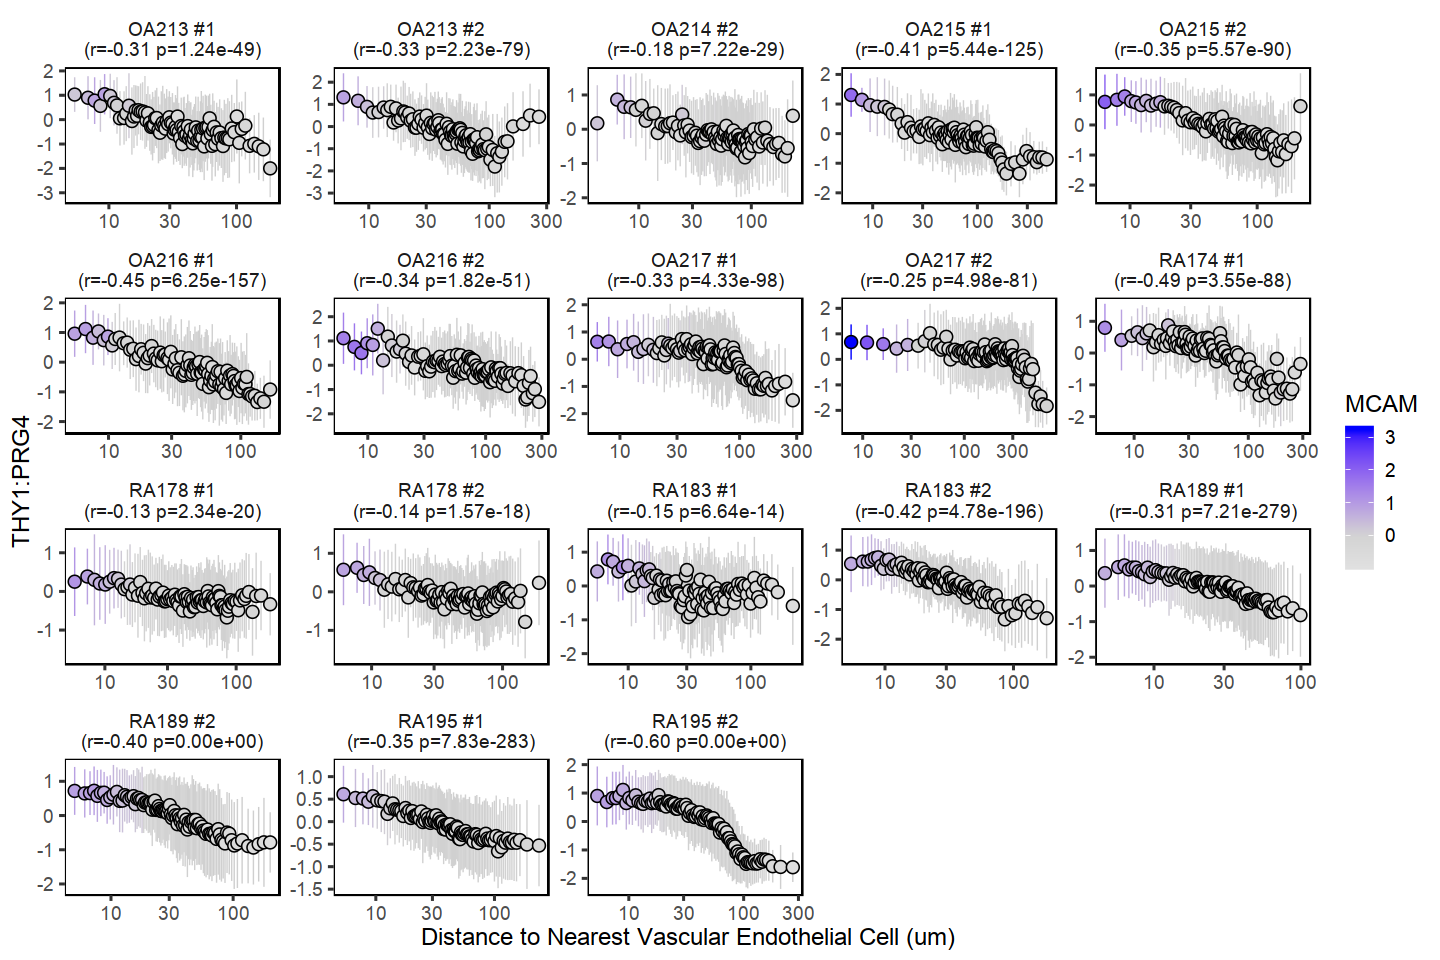

In [328]:
fig.size(8, 12)
data_if_binned %>% 
    subset(symbol == "ratio") %>% 
    subset(ncells_image > 1000) %>% 
    cbind(    
        MCAM = data_if_binned %>% subset(symbol == "CD146") %>% with(yval)    
    ) %>% 
    dplyr::inner_join(cor_res) %>% 
    dplyr::mutate(ID = sprintf("%s #%s\n(r=%.2f p=%.2e)", Sample, Image.number, estimate, p.value)) %>% 
    ggplot(aes(xval, yval)) + 
        geom_errorbar(width=0, aes(ymin=yval - ysd, ymax=yval + ysd, color = MCAM), size = .3) +
        geom_point(shape = 21, size = 3, aes(fill = MCAM)) + 
        scale_color_gradient2(low = "grey", high = "blue", mid = "lightgrey") + 
        scale_fill_gradient2(low = "white", high = "blue", mid = "lightgrey") + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + 
        theme(panel.background = element_rect()) + 
        labs(y = "THY1:PRG4", x = "Distance to Nearest Vascular Endothelial Cell (um)") + 
        guides(color = FALSE) + 
        scale_x_log10() + 
        facet_wrap(~ID, scales = "free") + 
        NULL


ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/if_corr.pdf', device = "pdf", 
       dpi = 300, width = 12, height = 8, useDingbats = FALSE)  


# Fibroblast stability experiment

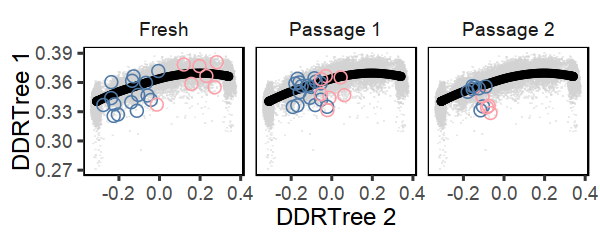

In [322]:
fig.size(2, 5)
with(bulk, {
(    p1 <<- ddr_stim %>% data.frame() %>% 
        cbind(metadata) %>% 
        subset(Experiment == 'Fibroblast stability') %>% 
        dplyr::mutate(condition = ifelse(condition == "Day7/8", "Passage 1", condition)) %>% 
        dplyr::mutate(condition = ifelse(condition == "Day 14", "Passage 2", condition)) %>%             
        dplyr::mutate(condition = factor(condition, c("Fresh", "Passage 1", "Passage 2"))) %>%
        dplyr::mutate(Cell.type = as.character(Cell.type)) %>% 
        dplyr::mutate(Cell.type = ifelse(grepl("CD34", Cell.type), "CD90+", Cell.type)) %>% 
        subset(Cell.type != 'CD146+') %>% 
        ggplot(aes(-X2, X1, color = Cell.type)) +
            geom_point_rast(dpi = 300, height = 1, width = 1, 
                data = tissue$ddrtree_res$Z %>% data.frame(), 
                color = 'lightgrey', alpha = .5, shape = '.'
            ) + 
            geom_point(data = data.frame(t(tissue$ddrtree_res$Y)), color = 'black') + 
            geom_point(shape = 21, size = 3, position = position_jitter(height = .02)) + 
            labs(x = "DDRTree 2", y = "DDRTree 1") + 
            theme_tufte(base_size = 14, base_family = "Helvetica") + 
            theme(panel.background = element_rect()) + 
            scale_color_manual(values = c(tableau_color_pal()(10)[8], tableau_color_pal()(10)[1])) + 
            guides(color = FALSE) + 
            facet_wrap(~condition) + 
            NULL
  )  
})

# ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/if_scatter', device = "pdf", 
#        dpi = 300, width = 16, height = 10, useDingbats = FALSE)  


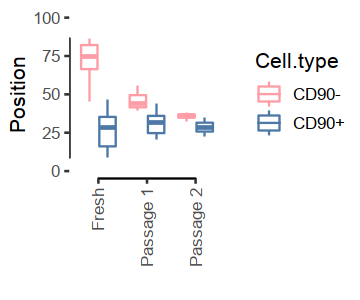

In [323]:
fig.size(2.5, 3)
with(bulk, {
(    p2 <<- metadata %>% 
        subset(Experiment == 'Fibroblast stability') %>% 
        dplyr::mutate(condition = ifelse(condition == "Day7/8", "Passage 1", condition)) %>% 
        dplyr::mutate(condition = ifelse(condition == "Day 14", "Passage 2", condition)) %>%             
        dplyr::mutate(condition = factor(condition, c("Fresh", "Passage 1", "Passage 2"))) %>%
        dplyr::mutate(Cell.type = as.character(Cell.type)) %>% 
        dplyr::mutate(Cell.type = ifelse(grepl("CD34", Cell.type), "CD90+", Cell.type)) %>% 
        subset(Cell.type != 'CD146+') %>% 
        ggplot(aes(condition, 100 - time, color = Cell.type)) + 
        geom_boxplot(outlier.shape = NA) + 
        theme_tufte(base_size = 12) + geom_rangeframe(col = "black") + 
        theme(plot.title = element_text(size = 14, hjust = .5), 
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) + 
#         scale_fill_manual(values = c(tableau_color_pal()(10)[3], tableau_color_pal()(10)[1])) + 
        scale_color_manual(values = c(tableau_color_pal()(10)[8], tableau_color_pal()(10)[1])) + 
#         scale_color_manual(values = c(tableau_color_pal()(10)[3], tableau_color_pal()(10)[1])) + 
#         scale_fill_tableau() +
        ylim(0, 100) + 
        labs(x = "", y = "Position")
)    
})


In [329]:
with(bulk, {
    metadata %>% 
        subset(Experiment == 'Fibroblast stability') %>% 
        dplyr::mutate(condition = ifelse(condition == "Day7/8", "Passage 1", condition)) %>% 
        dplyr::mutate(condition = ifelse(condition == "Day 14", "Passage 2", condition)) %>%             
        dplyr::mutate(condition = factor(condition, c("Fresh", "Passage 1", "Passage 2"))) %>%
        dplyr::mutate(Cell.type = as.character(Cell.type)) %>% 
        dplyr::mutate(Cell.type = ifelse(grepl("CD34", Cell.type), "CD90+", Cell.type)) %>% 
        subset(Cell.type != 'CD146+') %>% 
    with(table(Cell.type, condition))
        
})

         condition
Cell.type Fresh Passage 1 Passage 2
    CD90-     7         7         4
    CD90+    15        16         8

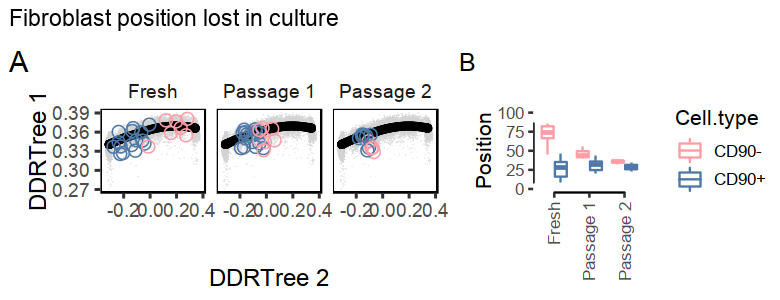

In [324]:
fig.size(2.5, 6.5)
p1 + 
p2 + 
plot_layout(nrow = 1, widths = c(3, 1)) +
    patchwork::plot_annotation(title = "Fibroblast position lost in culture", tag_levels = 'A')

ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/stability.pdf', device = "pdf", 
       dpi = 300, width = 6.5, height = 2.5, useDingbats = FALSE)  


# Correlation of %CD90+ with %ECs


In [291]:
str <- "	endothelial cells	CD90+ fibroblasts
RA160525A	22.7	92.5
RA160902	18.6	63.7
RA160715	17.3	91.9
CL160526	15.7	70.7
RA160908	15.2	68.1
RA160425	13.8	88.5
OA160822B	9	81.7
RA160513	6.99	91.1
OA160822A	6.02	51.9
OA160609(1)	5.38	55.4
RA160531	5.32	74.4
Bx16006	3.67	87.2
OA160512	3.61	38.85
OA160617	3.4	62.6
OA160908	2.76	17.41
RA160606	2.74	5.59
OA160609(2)	1.69	47.4
RA160929	1.67	40.4
OA160512A	1.434	18.6
OA160819	0.88	36.1
OA160512	0.71	30.9
OA032816	0.62	29.5
OA160909		"

fig.size(3, 5)
data_df <- fread(text = str) %>% 
    subset(!is.na(`endothelial cells`) & !is.na(`CD90+ fibroblasts`)) 

cor_res <- cor.test(~ `endothelial cells` + `CD90+ fibroblasts` , data_df, method = 'spearman') %>% broom::tidy()

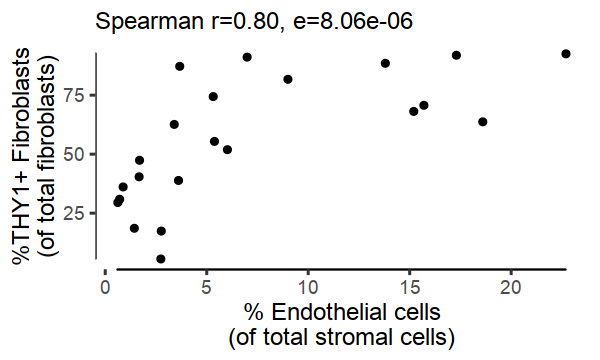

In [297]:
data_df %>% 
    ggplot(aes(`endothelial cells`, `CD90+ fibroblasts`)) + 
        geom_point() + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + 
        geom_rangeframe() + 
        labs(y = '%THY1+ Fibroblasts\n(of total fibroblasts)', 
             x = '% Endothelial cells\n(of total stromal cells)', 
             subtitle = sprintf('Spearman r=%.2f, e=%.2e', cor_res$estimate, cor_res$p.value)) + 
#         scale_y_log10() + 
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/endo_proportion.pdf', device = "pdf", 
       dpi = 300, width = 5, height = 3, useDingbats = FALSE)  


## Doppler


In [337]:
str <- "0	1	2
61.22	70.84	92.64
48.37	75	98.43
61.17	96.29	97.65
83.32	91.09	90.1
	93.85	89.02
66.38		80.6
53.06		95.95
		99.86
		78.57"

# fig.size(3, 5)
data_df <- fread(text = str, skip = 1) %>% 
    tidyr::gather(dop, val) %>% 
    dplyr::mutate(dop = as.numeric(gsub('V', '', dop))) %>% 
    subset(!is.na(val)) 

cor_res <- cor.test(~ `dop` + `val` , data_df, method = 'spearman') %>% broom::tidy()

Warning message in cor.test.default(x = c(1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, :
“Cannot compute exact p-value with ties”

In [339]:
table(data_df$dop)


1 2 3 
6 5 9 

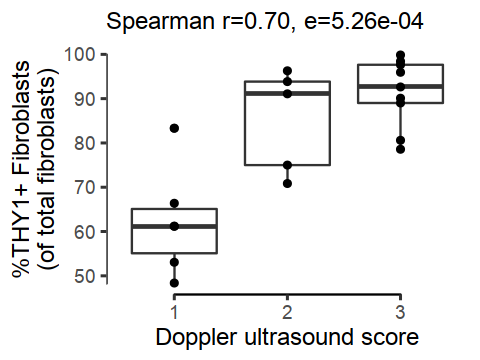

In [321]:
fig.size(3, 4)
data_df %>% 
    ggplot(aes(dop, val)) + 
        geom_boxplot(data = . %>% dplyr::mutate(dop = factor(dop))) + 
        geom_point() + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + 
        geom_rangeframe() + 
        labs(y = '%THY1+ Fibroblasts\n(of total fibroblasts)', 
             x = 'Doppler ultrasound score', 
             subtitle = sprintf('Spearman r=%.2f, e=%.2e', cor_res$estimate, cor_res$p.value)) + 
#         scale_x_continuous(breaks = 1:3) +
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/doppler.pdf', device = "pdf", 
       dpi = 300, width = 4, height = 3, useDingbats = FALSE)  
